In [1]:
import numpy as np
from vpsto.vpsto import VPSTO, VPSTOOptions
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from IPython.display import HTML

from jax import jit
import jax.numpy as jnp

%load_ext autoreload
%autoreload 2

In [2]:
@jit
def block_rollout_jax(X0, U, A_block, B_block, bounds):
    """ Rollout the environment for a given number of steps with vectorized dynamics
    
    Args:
        X0: Shape (num_obs, 2 * num_dofs), representing the initial state for each particle.
        U: Shape (num_obs, num_steps * num_dofs)
    return: 
        X: Shape (num_obs, num_steps, num_dofs), representing the final state for each particle over k time steps.
    """
    num_obs, num_states = X0.shape # static
    # Compute final state vectors for each particle
    X_batch = (A_block @ X0.T).T + (B_block @ U.T).T # (num_particles, num_steps * num_dofs)
    # Reshape X_vec back to (num_rollouts, num_steps, num_dofs)
    X = X_batch.reshape((num_obs, -1, num_states)).transpose((1, 0, 2))
    
    # Enforce bounds if necessary by reflecting positions and velocities
    vel_reflection_mask = 1 - 2 * (jnp.logical_or(X[:, :, :2] < bounds[:, 0], X[:, :, :2] > bounds[:, 1]))
    Pos = bounds[:,1] - jnp.abs(bounds[:,0] - bounds[:,1] + jnp.abs(X[:, :, :2] - bounds[:,0]))
    Vel = X[:, :, 2:] * vel_reflection_mask
    return jnp.concatenate((Pos, Vel), axis=2)

In [3]:
class RandomWalkObs:
    def __init__(self, var_a, num_steps, X0, dt, v_max, radii, bounds,
                 mean_a=np.zeros(2), clip_velocity=False): 
        self.x = X0  # initialize position & velocity
        self.v_max = v_max   # maximum velocity
        self.dt = dt
        self.n_dof = mean_a.shape[0]
        self.sigma_a = var_a * np.eye(2)  # covariance matrix for acceleration
        self.mean_a = mean_a # mean acceleration
        self.num_steps = num_steps # number of rollouts to simulate
        self.num_obs = X0.shape[0]
        self.A = np.array([[1., 0., self.dt, 0.], 
                    [0., 1., 0., self.dt], 
                    [0., 0., 1., 0.],
                    [0., 0., 0., 1.]])
        self.B = np.array([[0.5 * self.dt**2, 0, self.dt, 0], 
                           [0, 0.5 * self.dt**2, 0, self.dt]]).T
        self.A_block, self.B_block = self.get_block_matrices(self.num_steps)

        self.clip_velocity = clip_velocity
        # repeat bounds for all obstacles
        max_radius = np.max(radii)
        self.bounds = bounds + np.array([[max_radius, -max_radius], [max_radius, -max_radius]])

    def get_block_matrices(self, k):
        # Compute block matrices for computing the rollout in one step as X = A_block * x0 + B_block * U
        Dx, Du = self.B.shape
        A_block = np.zeros((k*Dx, Dx))
        B_block = np.zeros((k*Dx, k*Du))
        for i in range(k):
            A_block[Dx*i:Dx*(i+1), :] = np.linalg.matrix_power(self.A, i+1)
            for j in range(i+1):
                B_block[Dx*i:Dx*(i+1), Du*j:Du*(j+1)] = np.linalg.matrix_power(self.A, i-j) @ self.B

        return A_block, B_block

    def block_rollout(self, X0):
        """ Rollout the environment for a given number of steps with vectorized dynamics
        Args:
            X0: Shape (num_obs, 2 * num_dofs), representing the initial state for each obstacle.
        return: 
            X: Shape (num_obs, k, num_dofs), representing the final state for each particle over k time steps.
        """
        U = np.random.multivariate_normal(
            self.mean_a, self.sigma_a, size=(self.num_obs, self.num_steps))\
                .reshape(self.num_obs, -1) # (num_obs, num_rollouts * num_dofs)

        X = np.array(block_rollout_jax(X0, U, self.A_block, self.B_block, self.bounds))

        return X


In [26]:
def animate(rollouts, radii, bounds, dt, sol=None, robot_rad=None, save_path=None):
    fig, ax = plt.subplots(figsize=(5, 5), dpi=100, facecolor='w', edgecolor='k')
    fps = 5 #30 
    dt_ani = 1/fps 
    colors = ['r', 'b', 'g', 'y', 'm', 'c', 'k']

    obs_patches = []
    axes = plt.gca()
    axes.set_xlim(*bounds[0,:])
    axes.set_ylim(*bounds[1,:])
    axes.grid()

    for o in range(rollouts.shape[1]): # for each obstacle 
        circle = plt.Circle((rollouts[0, o, 0], rollouts[0, o, 1]), 
                            radii[o], color=colors[o], edgecolor=None, alpha=1)
        obs_patches.append(circle)
        ax.add_patch(circle)
    if sol is not None: 
        robot = plt.Circle((sol[0, 0], sol[0, 1]), robot_rad, color='k', edgecolor=None, alpha=1)
        ax.add_patch(robot)
        robot_traj, = ax.plot([], [], 'k', lw=1, zorder=10)
            
    def animate(i_):
        i = np.min([rollouts.shape[0]-1, int(i_*dt_ani/dt)])
        if sol is not None: 
            i = np.min([i, sol.shape[0]-1])
        for j in range(len(obs_patches)):
            obs_patches[j].center = (rollouts[i, j, 0], rollouts[i, j, 1])
        if sol is not None:
            robot.center = (sol[i, 0], sol[i, 1])
            robot_traj.set_data(sol[:i, 0], sol[:i, 1])
        return *obs_patches, robot, 
    T = min(rollouts.shape[0] * dt, sol.shape[0] * dt) if sol is not None else rollouts.shape[0] * dt
    anim = animation.FuncAnimation(fig, animate, frames=int((T+0.5)*fps), interval=dt_ani*1e3)#, blit=True, repeat=False)

    if save_path is not None:
        print('Saving animation to: {}'.format(save_path))
        anim.save(save_path, writer='ffmpeg', fps=fps, dpi=200)

    plt.close()
    return anim.to_jshtml()

In [27]:
## initialize the environment
X0 = np.array([
    [1, 1, 0, 0],
    [4, 4, -0.5, -0.5]
]) # (num_obs, 4)
var_a = 0.5 # variance of acceleration - assumed to be the same across obstacles for now
radii = np.array([0.5, 0.5]) # radius of each obstacle
dt = 0.05
T_max = 15
num_steps = int(T_max/dt)
bounds = np.array([[0,5], [0,5]])
ndof = 2

In [6]:
env = RandomWalkObs(var_a, num_steps, X0, dt, v_max=1, 
                    radii=radii, mean_a=np.zeros(ndof), bounds=bounds)
rollouts = env.block_rollout(X0)
print(rollouts.shape)

(300, 2, 4)


In [7]:
ani = animate(rollouts, radii, bounds, dt)
HTML(ani)

In [8]:
@jit
def collision_check_batch_jit(x_robot, r_robot, obs_preds, radii):
    """ Check if a circle with center x=(x,y) and radius r collides with any of the objects in the environment

    Args:
        x (numpy ndarray (pop_size, num_timesteps, 2)): x, y coordinates of robot trajectory
        r (float): radius of the robot
        obs_preds (numpy ndarray (num_obs, num_timesteps, particles, 2)): x, y coordinates of obstacle trajectories
        obs_preds (numpy ndarray (num_steps, num_obs, 2))
    Returns:
        bool: True if collision, False otherwise (pop_size, num_obs, particles, num_timesteps)
    """
    obs_trajs = jnp.transpose(obs_preds, (1, 0, 2)) # (num_obs, num_steps, 2)
    dists_sq = jnp.sum((x_robot[:, jnp.newaxis, :, :] - obs_trajs[jnp.newaxis, :, :, :])**2, axis=-1) # (pop_size, num_obs, num_timesteps)
    dists_sq_threshold = ((r_robot + radii)**2)[jnp.newaxis, :, jnp.newaxis] # (1, num_obs, 1)
    return dists_sq < dists_sq_threshold

In [17]:
### initialize VPSTO 
class Loss():
    def __init__(self, vpsto, xr_d, bounds, radii, robot_rad, dt, T_max, rollouts, pos_key='pos', vel_key='vel'): 
        self.xr_d = xr_d # goal 
        self.bounds = bounds
        self.radii = radii
        self.robot_rad = robot_rad
        self.dt = dt
        self.T_max = T_max
        self.rollouts = rollouts
        self.pos_key = pos_key
        self.vel_key = vel_key
        self.vpsto = vpsto

    def equalize_pop_time_resolution(self, pop):
        via_points = pop['p_via']
        x0 = pop[self.pos_key][:,0]
        dx0 = pop[self.vel_key][:,0]
        dxT = np.zeros_like(dx0)
        T = pop['T']
        pop_size = x0.shape[0]
        _N_eval_max = int(self.T_max / self.dt) + 1
        t = np.linspace(0, self.T_max, _N_eval_max)
        t_batch = np.tile(t, (pop_size, 1))
        s_batch = t_batch / T[:,None] # shape = [pop_size, _N_eval_max]
        s_batch_vec = s_batch.flatten() # shape = [pop_size * _N_eval_max]

        Phi_batch_vec_jax, _, _ = self.vpsto.vptraj.obf.get_basis_jax(s_batch_vec)
        Phi_batch_vec = np.array(Phi_batch_vec_jax)

        Phi_batch = Phi_batch_vec.reshape((pop_size, -1, Phi_batch_vec.shape[-1])) # shape = [pop_size, 2*_N_eval_max, num_basis]
        xT = pop[self.pos_key][:,-1]
        w = np.concatenate((x0, via_points, xT, dx0, dxT), axis=-1) # shape = [pop_size, num_basis]
        w[:, -4:] *= T[:,None] # scale dq0 and dqT with T
        q_batch = np.sum(Phi_batch * w[:,None,:], axis=-1) # shape = [pop_size, 2*_N_eval_max]
        new_pop = q_batch.reshape((pop_size, _N_eval_max, -1)) # shape = [pop_size, _N_eval_max, 2]
        return new_pop
    
    def loss_collision(self, pop):
        """ Approximates the collision probability of the robot with the environment, i.e. the chance constraint 
        """
        pop_size, N_eval, ndof = pop[self.pos_key].shape  # [N, N_eval, 2]
        num_steps = self.rollouts.shape[0]
        costs = np.zeros(pop_size)
        pop_ = self.equalize_pop_time_resolution(pop) # (pop_size, N_eval_col, ndof)
        collisions = collision_check_batch_jit(
            pop_[:, 1:num_steps+1], self.robot_rad, self.rollouts[:, :, :2], self.radii) # (pop_size, num_obs, N_eval_col)
        per_obs_collision = jnp.any(collisions, axis=2) # (pop_size, num_obs)
        costs = 100 * jnp.sum(per_obs_collision, axis=1) # (pop_size,)
        return np.array(costs)
    
    def loss_limits(self, pop):
        q = pop[self.pos_key]
        d_min = np.maximum(np.zeros_like(q), self.bounds[:,0] - q)
        d_max = np.maximum(np.zeros_like(q), q - self.bounds[:,1])
        return np.sum(d_min > 0.0, axis=(1, 2)) + np.sum(d_max > 0.0, axis=(1, 2))
    
    def loss_full_horizon(self, pop):
        cost_limits = self.loss_limits(pop)
        cost_collision = self.loss_collision(pop)
        cost = pop['T'] + 1e8 * cost_limits + 1e6 * cost_collision 
        return cost
    
    

In [18]:
### task 
xr_d = np.array([1, 4])
xr_0 = np.array([4, 1])
robot_rad = 0.25

In [19]:
### initialize VPSTO 
opt = VPSTOOptions(ndof=2)
opt.vel_lim = np.array([1, 1])
opt.acc_lim = np.array([10, 10]) 
opt.N_via = 2
opt.N_eval = 100
opt.pop_size = 25
opt.sigma_init = 20
opt.max_iter = 200
opt.verbose = True 

vpsto = VPSTO(opt)
loss = Loss(vpsto, xr_d, bounds, radii, robot_rad, dt, T_max, rollouts)

In [20]:
### run VPSTO
sol = vpsto.minimize(
            loss.loss_full_horizon, xr_0, qT=xr_d, 
            dqT=np.zeros_like(xr_d)
            )
T = sol.T_best
resulting_loss = sol.c_best
# Retrieve solution trajectory
t = np.linspace(0, T, int(T / dt) + 1)
X, _, _ = sol.get_posvelacc(t)

print('\tFinal motion duration: ', T)
print('\tFinal loss: ', resulting_loss)

VP-STO finished after 111 iterations with a final loss of 5.570521068347566
	Final motion duration:  5.570521068347566
	Final loss:  5.570521068347566


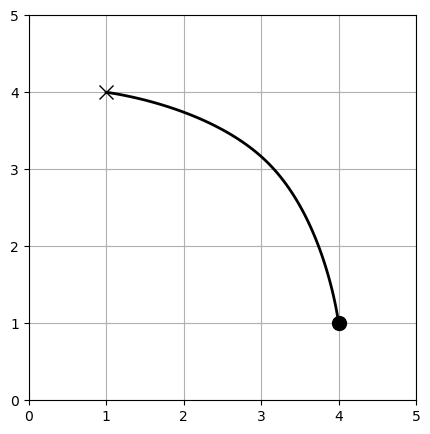

In [21]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=100, facecolor='w', edgecolor='k')
axes = plt.gca()
axes.set_xlim(*bounds[0,:])
axes.set_ylim(*bounds[1,:])
axes.grid()
ax.plot(X[:,0], X[:,1], 'k-', linewidth=2)
ax.plot(X[0,0], X[0,1], 'ko', markersize=10)
ax.plot(X[-1,0], X[-1,1], 'kx', markersize=10)
plt.show()

In [28]:
ani = animate(rollouts, radii, bounds, dt, sol=X, robot_rad=robot_rad)
HTML(ani)